#Image Splicing Forgery Detection with RRU-Net and FSM


---


@Authors:
*   Alessandro Lambertini
*   Denise Landini

##Import libraries

In [7]:
import os
import time
import random
import numpy as np

from imageio import imread

from skimage.transform import resize
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Function
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
from IPython.display import HTML, display

def progress(value, max=100):
  return HTML("""
    <progress
      value='{value}'
      max='{max}',
      style='width: 50%'
    >
        {value}
    </progress>
  """.format(value=value, max=max))

In [8]:
from google.colab import drive
drive.mount('/content/drive')

# global variables to dataset
dir = 'drive/MyDrive/Colab Notebooks/V&P/Final Project/'

Mounted at /content/drive


##RRU-Net

###blocks of RRU-NET

In [9]:
class RRU_conv(nn.Module):
  def __init__(self, nin, nout):
    super(RRU_conv, self).__init__()

    self.rru_c = torch.nn.Sequential(
      # first convolution
      torch.nn.Conv2d(nin, nout, 3, padding=2, dilation=2),
      torch.nn.GroupNorm(32, nout),
      torch.nn.ReLU(inplace=True),

      # second convolution
      torch.nn.Conv2d(nout, nout, 3, padding=2, dilation=2),
      torch.nn.GroupNorm(32, nout),
    )

  def forward(self, x):
    x = self.rru_c(x)
    return x

class RRU_Block_E(nn.Module):
  def __init__(self, nin, nout):
    super(RRU_Block_E, self).__init__()

    self.act = nn.ReLU(inplace=True)

    self.rru_c1 = RRU_conv(nin, nout)

    # Residual Propagation
    self.Residual_Propagation_c = torch.nn.Conv2d(nin, nout, kernel_size=1, bias=False)
    self.Residual_Propagation_n = torch.nn.GroupNorm(32, nout)

    # Residual Feedback
    self.Residual_Feedback = torch.nn.Conv2d(nout, nin, kernel_size=1, bias=False)

  def forward(self, x):
    # Residual Propagation
    rru_c1 = self.rru_c1(x)
    rp = self.Residual_Propagation_n(self.Residual_Propagation_c(x))

    rp = self.act(rru_c1 + rp)

    # Residual Feedback
    rf = self.Residual_Feedback(rp)
    x = torch.mul(1 + torch.sigmoid(rf), x)

    # std path
    rru_c2 = self.rru_c1(x)
    rp = self.Residual_Propagation_n(self.Residual_Propagation_c(x))

    out = self.act(rru_c2 + rp)
    return out


class RRU_block_D(nn.Module):
  def __init__(self, nin, nout):
    super(RRU_block_D, self).__init__()

    self.act = torch.nn.ReLU(inplace=True)
    
    self.cT1 = torch.nn.ConvTranspose2d(nin // 2, nin // 2, 2, stride=2)
    self.n1 = torch.nn.GroupNorm(32, nin // 2)

    self.rru_c1 = RRU_conv(nin, nout)
      
    # Residual Propagation
    self.Residual_Propagation_c = torch.nn.Conv2d(nin, nout, kernel_size=1, bias=False)
    self.Residual_Propagation_n = torch.nn.GroupNorm(32, nout)

    # Residual Feedback
    self.Residual_Feedback = torch.nn.Conv2d(nout, nin, kernel_size=1, bias=False)

  def forward(self, x1, x2):

    x1 = self.n1(self.cT1(x1))
    x1 = F.pad(x1, (x2.size()[3] - x1.size()[3], 0,
                    x2.size()[2] - x1.size()[2], 0))
    
    x = self.act(torch.cat([x2, x1], dim=1))

    # Residual Propagation
    rru_c1 = self.rru_c1(x)
    rp = self.Residual_Propagation_n(self.Residual_Propagation_c(x))

    rp = self.act(rp + rru_c1)

    # Residual Feedback
    rf = self.Residual_Feedback(rp)
    x = torch.mul(1 + torch.sigmoid(rf), x)

    # std path
    rru_c2 = self.rru_c1(x)
    rp = self.Residual_Propagation_n(self.Residual_Propagation_c(x))

    out = self.act(rru_c2 + rp)
    return out

###FSM: Feature similarity module

In [10]:
class LambdaLayer(nn.Module):
  def __init__(self, lambd):
    super(LambdaLayer, self).__init__()
    self.lambd = lambd
  def forward(self, x):
    return self.lambd(x)

class FSM(nn.Module):
  def __init__(self, debug=False):
    super(FSM, self).__init__()
    self.debug = debug

    self.act = nn.ReLU()

    # [64, 512, 3, 3], expected input[1, 256, 24, 16]

    C = 256
    Co = int(C // 8)
    
    self.b1_1 = torch.nn.Conv2d(C, Co, kernel_size=3, stride=1, padding=1)
    self.b1_2 = torch.nn.BatchNorm2d(Co)

    self.dim1, self.dim2, channels = 24, 16, 32 # 14, 12, 128
    Ch = (channels // 2)
    if Ch < 1:
      Ch = 1
    self.Ch = Ch

    self.b2 = torch.nn.Conv2d(Co, Ch, kernel_size=1, stride=1, padding=0)
    self.b3 = torch.nn.Conv2d(Co, Ch, kernel_size=1, stride=1, padding=0)
    self.b4 = torch.nn.Conv2d(Co, Ch, kernel_size=1, stride=1, padding=0)

    self.b6 = torch.nn.ConvTranspose2d(Ch, channels, kernel_size=1, stride=1, padding=0)

    self.b7_1 = torch.nn.ConvTranspose2d(channels, C, kernel_size=3, stride=1, padding=1)
    self.b7_2 = torch.nn.BatchNorm2d(C)


  def forward(self, x):
    if self.debug:
      print("x.shape : ", x.shape)

    b1_1 = self.act(self.b1_1(x))
    if self.debug:
      print("b1_1.shape : ", b1_1.shape)
    b1_2 = self.b1_2(b1_1)
    if self.debug:
      print("b1_2.shape : ", b1_2.shape)
    
    b2 = self.act(self.b2(b1_2))
    if self.debug:
      print("b2.shape : ", b2.shape)
    b2 = torch.reshape(b2, (self.Ch, -1, 1, 1))
    if self.debug:
      print("b2.shape : ", b2.shape)
    b3 = self.act(self.b3(b1_2))
    if self.debug:
      print("b3.shape : ", b3.shape)
    b3 = torch.reshape(b3, (self.Ch, -1, 1, 1))
    if self.debug:
      print("b3.shape : ", b3.shape)
    b4 = self.act(self.b4(b1_2))
    if self.debug:
      print("b4.shape : ", b4.shape)
    b4 = torch.reshape(b4, (self.Ch, -1, 1, 1))
    if self.debug:
      print("b4.shape : ", b4.shape)
    
    b5 = b2@b3 # dot
    if self.debug:
      print("b5.shape : ", b5.shape)
    b5_size = b5.shape
    Lambda = LambdaLayer(lambda z: (1. / float(b5_size[-1])) * z)
    b5 = Lambda(b5)
    if self.debug:
      print("b5.shape : ", b5.shape)

    b6 = b5@b4 # dot
    if self.debug:
      print("b6.shape : ", b6.shape)
    b6 = torch.reshape(b6, (1, self.Ch, self.dim1, self.dim2))
    if self.debug:
      print("b6.shape : ", b6.shape)
    b6 = self.act(self.b6(b6))
    if self.debug:
      print("b6.shape : ", b6.shape)
    b6 = torch.add(b1_2, b6)
    if self.debug:
      print("b6.shape : ", b6.shape)
    
    b7_1 = self.act(self.b7_1(b6))
    if self.debug:
      print("b7_1.shape : ", b7_1.shape)
    b7_2 = self.b7_2(b7_1)
    if self.debug:
      print("b7_2.shape : ", b7_2.shape)
    out = torch.add(b7_2, x)
    if self.debug:
      print("out.shape : ", out.shape)
    
    return out

###evalDice

In [11]:
def evalDice(input, target):
  summ = torch.FloatTensor(1).cuda().zero_()
  for i, t in enumerate(zip(input, target)):
    summ = summ + DiceCoeff().forward(t[0], t[1])
  return summ / (i + 1)

class DiceCoeff(Function):
  def forward(self, input, target):
    self.save_for_backward(input, target)
    self.inter = torch.dot(input.view(-1), target.view(-1))
    self.union = torch.sum(input) + torch.sum(target) + 0.0001
    return (2 * self.inter.float() + 0.0001) / self.union.float()

    def backward(self, grad_output):
      input, target = self.saved_variables
      grad_input = None
      if self.needs_input_grad[0]:
        grad_input = grad_output * 2 * (target * self.union + self.inter) \
                      / self.union * self.union
      return grad_input, None

###Complete architecture of RRU-Net

In [12]:
class RRU_NET(nn.Module):
  def __init__(self, nin=3, nout=1, debug=False):
    super(RRU_NET, self).__init__()

    self.debug = debug

    # Encoder
    # first layer
    self.e1_1 = RRU_Block_E(nin, 32)
    self.e1_2 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # second layer
    self.e2_1 = RRU_Block_E(32, 64)
    self.e2_2 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # third layer
    self.e3_1 = RRU_Block_E(64, 128)
    self.e3_2 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # fourth layer
    self.e4_1 = RRU_Block_E(128, 256)
    self.e4_2 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # fifth layer
    self.encoder_output = RRU_Block_E(256, 256)
    # END Encoder

    # FSM
    self.decoder_input = FSM(self.debug)

    # Decoder
    # first layer
    self.d1_1 = RRU_block_D(512, 128)

    # second layer
    self.d2_1 = RRU_block_D(256, 64)

    # third layer
    self.d3_1 = RRU_block_D(128, 32)

    # fourth layer
    self.d4_1 = RRU_block_D(64, 32)

    # output
    self.decoder_output = torch.nn.Conv2d(32, nout, 1)

  def forward(self, x):
    if self.debug:
      print("x.shape : ", x.shape)

    # Encoder
    # first layer
    e1_1 = self.e1_1(x)
    if self.debug:
      print("e1_1.shape : ", e1_1.shape)
    e1_2 = self.e1_2(e1_1)
    if self.debug:
      print("e1_2.shape : ", e1_2.shape)
    
    # second layer
    e2_1 = self.e2_1(e1_2)
    if self.debug:
      print("e2_1.shape : ", e2_1.shape)
    e2_2 = self.e2_2(e2_1)
    if self.debug:
      print("e2_2.shape : ", e2_2.shape)

    # third layer
    e3_1 = self.e3_1(e2_2)
    if self.debug:
      print("e3_1.shape : ", e3_1.shape)
    e3_2 = self.e3_2(e3_1)
    if self.debug:
      print("e3_2.shape : ", e3_2.shape)

    # fourth layer
    e4_1 = self.e4_1(e3_2)
    if self.debug:
      print("e4_1.shape : ", e4_1.shape)
    e4_2 = self.e4_2(e4_1)
    if self.debug:
      print("e4_2.shape : ", e4_2.shape)

    # fifth layer
    encoder_output = self.encoder_output(e4_2)
    if self.debug:
      print("encoder_output.shape : ", encoder_output.shape)
    # END Encoder

    # FSM
    decoder_input = self.decoder_input(encoder_output)
    if self.debug:
      print("decoder_input.shape : ", decoder_input.shape)

    # Decoder
    # first layer
    d1_1 = self.d1_1(decoder_input, e4_1)
    if self.debug:
      print("d1_1.shape : ", d1_1.shape)

    # second layer
    d2_1 = self.d2_1(d1_1, e3_1)
    if self.debug:
      print("d2_1.shape : ", d2_1.shape)

    # third layer
    d3_1 = self.d3_1(d2_1, e2_1)
    if self.debug:
      print("d3_1.shape : ", d3_1.shape)

    # fourth layer
    d4_1 = self.d4_1(d3_1, e1_1)
    if self.debug:
      print("d4_1.shape : ", d4_1.shape)
    
    # output
    decoder_output = self.decoder_output(d4_1)
    if self.debug:
      print("decoder_output.shape : ", decoder_output.shape)
    
    return decoder_output

##Preprocessing of the data

###Load and split data

In [7]:
input_shape = (384, 256)
input_shape_w, input_shape_h = 384, 256
images_i = []
images_o = []

dir_img = dir+'dataset/label_in_wild/images/'
dir_mask = dir+'dataset/label_in_wild/masks/'

torch.cuda.empty_cache()

imgs_load = 184
i_path = sorted(os.listdir(dir_img))[0:imgs_load]
o_path = sorted(os.listdir(dir_mask))[0:imgs_load]

out = display(progress(0, len(i_path)-1), display_id=True)
print("Image input: %s" %str(input_shape))
print("Images in the dataset: %d" %(len(os.listdir(dir_img))))
print("Images loaded: %d" %(imgs_load))

for i in range(len(i_path)):
  appimgI = imread(dir_img+i_path[i])
  appimgO = imread(dir_mask+o_path[i])

  images_i.append(resize(appimgI, (input_shape_w, input_shape_h, 3)))
  images_o.append(resize(appimgO, (input_shape_w, input_shape_h)))

  del appimgI
  del appimgO
  out.update(progress(i, len(i_path)-1))

Image input: (384, 256)
Images in the dataset: 184
Images loaded: 184


In [8]:
splitting = 0.3
x_train, x_test, y_train, y_test = train_test_split(images_i, images_o, test_size=splitting, shuffle=False, random_state=2)

x_train = np.array([x_train[i] for i in range(len(x_train)) ]).astype(np.float32)
y_train = np.array([y_train[i] for i in range(len(y_train)) ]).astype(np.float32)
x_test = np.array([x_test[i] for i in range(len(x_test)) ]).astype(np.float32)
y_test = np.array([y_test[i] for i in range(len(y_test)) ]).astype(np.float32)

x_train = np.transpose(x_train, axes=[0, 3, 1, 2])
x_test = np.transpose(x_test, axes=[0, 3, 1, 2])

x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()

x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

print("dataset splitted in {}% train set and {}% test set".format((1-splitting)*100, (splitting)*100) )
print("number of train images: %d" %(x_train.shape[0]))
print("number of test images: %d" %(x_test.shape[0]))

print("x_train.shape : ", x_train.shape)
print("y_train.shape : ", y_train.shape)
print("x_test.shape : ", x_test.shape)
print("y_test.shape : ", y_test.shape)

dataset splitted in 70.0% train set and 30.0% test set
number of train images: 128
number of test images: 56
x_train.shape :  torch.Size([128, 3, 384, 256])
y_train.shape :  torch.Size([128, 384, 256])
x_test.shape :  torch.Size([56, 3, 384, 256])
y_test.shape :  torch.Size([56, 384, 256])


###Generate a random image input and the respective output

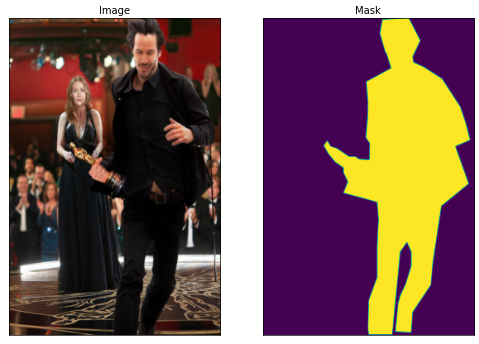

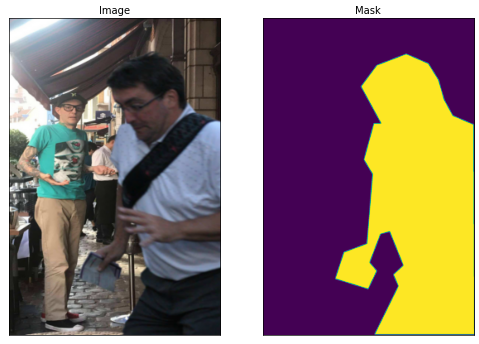

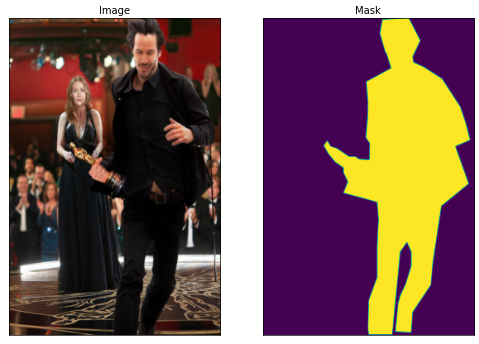

In [9]:
N = 3

for _ in range(N):
  i = random.randint(0, len(images_i)-1)
  f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 15), dpi=60)
  plt.setp(ax, xticks=[], yticks=[])
  ax[0].title.set_text("Image")
  ax[0].imshow(images_i[i]) # images_i
  ax[1].title.set_text("Mask")
  ax[1].imshow(images_o[i]) # images_o

##Train the model

In [13]:
dir_img = dir+'dataset/label_in_wild/images/'
dir_mask = dir+'dataset/label_in_wild/masks/'

net = RRU_NET(nin=3, nout=1).cuda()

nb_param = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("Net Structure: \n", net)

print("\nRRU Net Build")
print("Model Info --------------------")
print("Number of trainable parameters : "+str(nb_param))

Net Structure: 
 RRU_NET(
  (e1_1): RRU_Block_E(
    (act): ReLU(inplace=True)
    (rru_c1): RRU_conv(
      (rru_c): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (1): GroupNorm(32, 32, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (4): GroupNorm(32, 32, eps=1e-05, affine=True)
      )
    )
    (Residual_Propagation_c): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (Residual_Propagation_n): GroupNorm(32, 32, eps=1e-05, affine=True)
    (Residual_Feedback): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (e1_2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (e2_1): RRU_Block_E(
    (act): ReLU(inplace=True)
    (rru_c1): RRU_conv(
      (rru_c): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), di

Epoch: 1/10.
TRAINING


TESTING


dice_train: 0.2802, loss_train: 0.5192
dice_test: 0.0000, loss_test: 15.1578
time 16.06  s

Epoch: 2/10.
TRAINING


TESTING


dice_train: 0.2806, loss_train: 0.4794
dice_test: 0.0378, loss_test: 15.3935
time 16.36  s

Epoch: 3/10.
TRAINING


TESTING


dice_train: 0.2795, loss_train: 0.4770
dice_test: 0.0808, loss_test: 15.8747
time 16.47  s

Epoch: 4/10.
TRAINING


TESTING


dice_train: 0.2798, loss_train: 0.4772
dice_test: 0.0658, loss_test: 15.7107
time 16.13  s

Epoch: 5/10.
TRAINING


TESTING


dice_train: 0.2801, loss_train: 0.4756
dice_test: 0.0011, loss_test: 15.1430
time 15.93  s

Epoch: 6/10.
TRAINING


TESTING


dice_train: 0.2798, loss_train: 0.4723
dice_test: 0.1216, loss_test: 16.4692
time 15.95  s

Epoch: 7/10.
TRAINING


TESTING


dice_train: 0.2960, loss_train: 0.4614
dice_test: 0.0856, loss_test: 15.9831
time 16.04  s

Epoch: 8/10.
TRAINING


TESTING


dice_train: 0.2899, loss_train: 0.4593
dice_test: 0.0852, loss_test: 15.9612
time 16.13  s

Epoch: 9/10.
TRAINING


TESTING


dice_train: 0.2996, loss_train: 0.4518
dice_test: 0.0707, loss_test: 15.6067
time 16.05  s

Epoch: 10/10.
TRAINING


TESTING


dice_train: 0.2989, loss_train: 0.4503
dice_test: 0.0807, loss_test: 15.6805
time 15.97  s



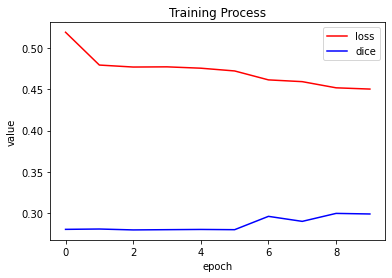

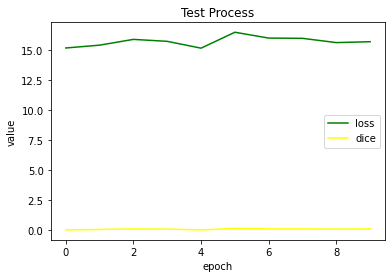

In [120]:
NUM_EPOCHS = 10

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)
criterion = nn.BCELoss()

loss_train = []
dice_train = []
loss_test = []
dice_test = []

for epoch in range(NUM_EPOCHS):
  app_loss_train = []
  app_dice_train = []
  app_loss_test = []
  app_dice_test = []

  print('Epoch: {}/{}.'.format(epoch + 1, NUM_EPOCHS))
  print("TRAINING")
  net.train()
  start_epoch = time.time()

  appLoss = 0
  out = display(progress(0, len(x_train)-1), display_id=True)
  start_pat = time.time()
  for i in range(len(x_train)):
    start_batch = time.time()

    output = net(x_train[i].reshape((1, *(x_train[i].shape))))
    output = torch.sigmoid(output)

    loss = criterion(output.view(-1), y_train[i].view(-1))
    app_loss_train.append(loss.cpu().item())
    app_dice_train.append(evalDice(output, y_test).item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    out.update(progress(i, len(x_train)-1))

  print("TESTING")
  out_disp = display(progress(0, len(x_test)-1), display_id=True)
  for i in range(len(x_test)):

    output = net(x_test[i].reshape((1, *(x_train[i].shape))))
    output = (torch.sigmoid(output) > 0.5).float()

    loss = criterion(output[0][0], y_test[i])
    app_loss_test.append(loss.cpu().item())
    app_dice_test.append(evalDice(output, y_test).item())

    out_disp.update(progress(i, len(x_test)-1))

  
  loss_train.append(sum(app_loss_train)/len(app_loss_train))
  dice_train.append(sum(app_dice_train)/len(app_dice_train))
  loss_test.append(sum(app_loss_test)/len(app_loss_test))
  dice_test.append(sum(app_dice_test)/len(app_dice_test))

  print("dice_train: {:.4f}, loss_train: {:.4f}".format(dice_train[-1], loss_train[-1]))
  print("dice_test: {:.4f}, loss_test: {:.4f}".format(dice_test[-1], loss_test[-1]))
  print("time {:.2f}".format(time.time() - start_pat), " s\n")

fig = plt.figure()
plt.title('Training Process')
plt.xlabel('epoch')
plt.ylabel('value')
l1, = plt.plot(loss_train, c='red')
l2, = plt.plot(dice_train, c='blue')
plt.legend(handles=[l1, l2], labels=['loss', 'dice'], loc='best')

fig = plt.figure()
plt.title('Test Process')
plt.xlabel('epoch')
plt.ylabel('value')
l1, = plt.plot(loss_test, c='green')
l2, = plt.plot(dice_test, c='yellow')
plt.legend(handles=[l1, l2], labels=['loss', 'dice'], loc='best')

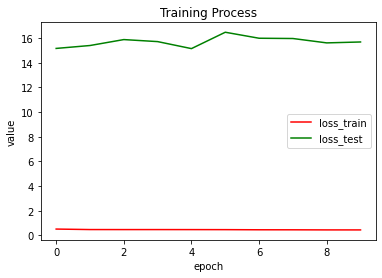

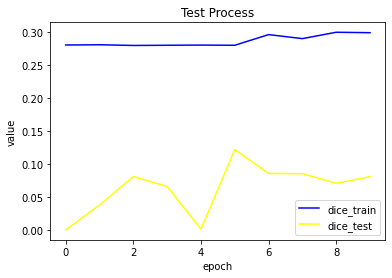

In [121]:
fig = plt.figure()
plt.title('Training Process')
plt.xlabel('epoch')
plt.ylabel('value')
l1, = plt.plot(loss_train, c='red')
l2, = plt.plot(loss_test, c='green')

plt.legend(handles=[l1, l2], labels=['loss_train', 'loss_test'], loc='best')

fig = plt.figure()
plt.title('Test Process')
plt.xlabel('epoch')
plt.ylabel('value')
l1, = plt.plot(dice_train, c='blue')
l2, = plt.plot(dice_test, c='yellow')
plt.legend(handles=[l1, l2], labels=['dice_train', 'dice_test'], loc='best')


----- Image: 0 -----


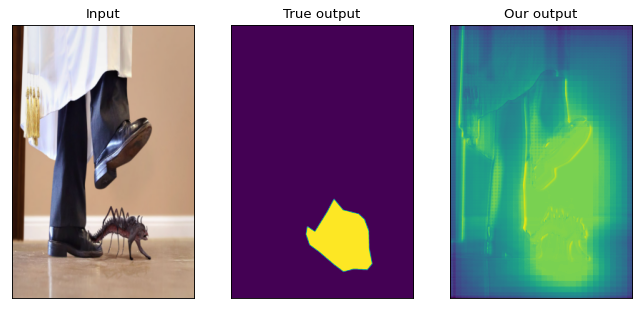


----- Image: 1 -----


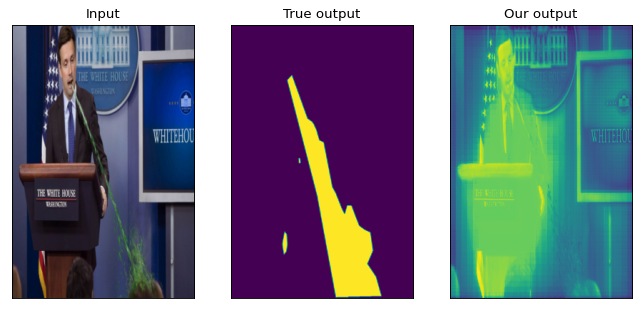


----- Image: 2 -----


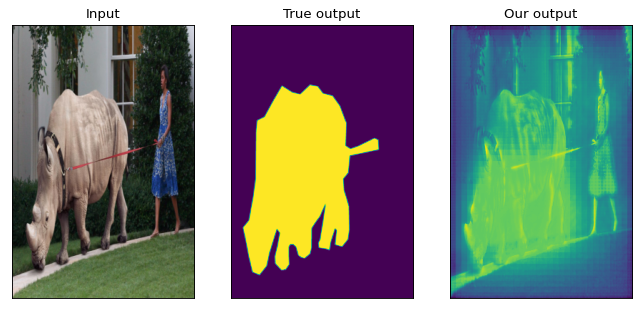


----- Image: 3 -----


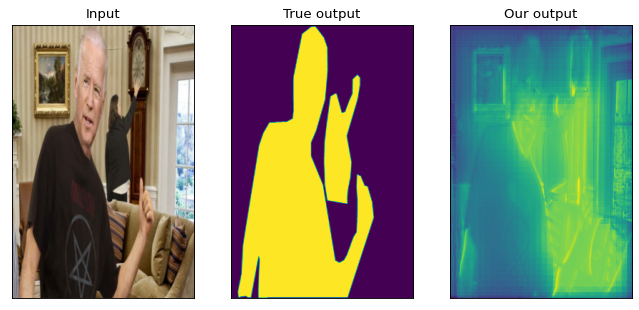


----- Image: 4 -----


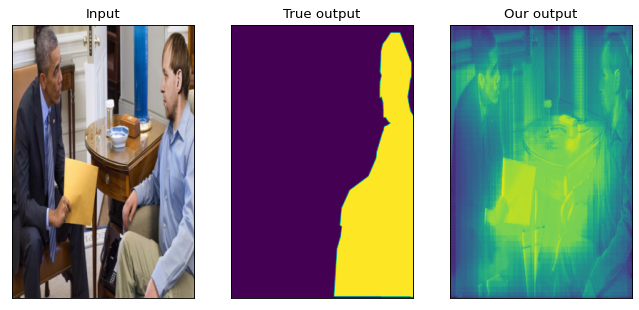

In [114]:
N = 5
pos = []
while len(pos) < N:
  app = np.random.randint(0, len(x_test)-1)
  if not app in pos:
    pos.append(app)

in_m = np.array([x_train[i].cpu().detach().numpy() for i in pos]) # x_test
in_m = torch.from_numpy(in_m).cuda()
true_out_m = np.array([y_train[i].cpu().detach().numpy() for i in pos]) # y_test

out_m = []
for i in range(len(in_m)):
  out_m.append(net( torch.from_numpy(in_m[i].cpu().detach().numpy()).cuda().reshape((1, *(x_train[i].shape))) ))

for j in range(len(out_m)):
  print("\n----- Image: %d -----" %j)
  f, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5), dpi=80)
  plt.setp(ax, xticks=[], yticks=[])
  ax[0].title.set_text("Input")
  ax[0].imshow( np.transpose(in_m[j].cpu().detach().numpy(), axes=[1, 2, 0]) )
  ax[1].title.set_text("True output")
  ax[1].imshow( true_out_m[j] )
  ax[2].title.set_text("Our output")
  ax[2].imshow( out_m[j].cpu().detach().numpy().reshape((384, 256)) )
  plt.show()


----- Image: 0 -----


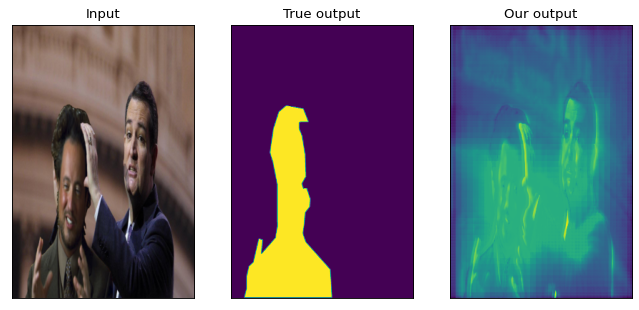


----- Image: 1 -----


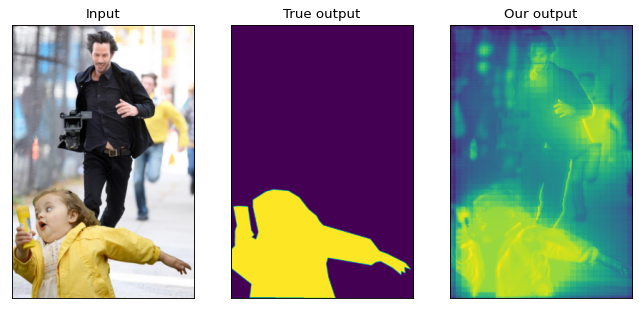


----- Image: 2 -----


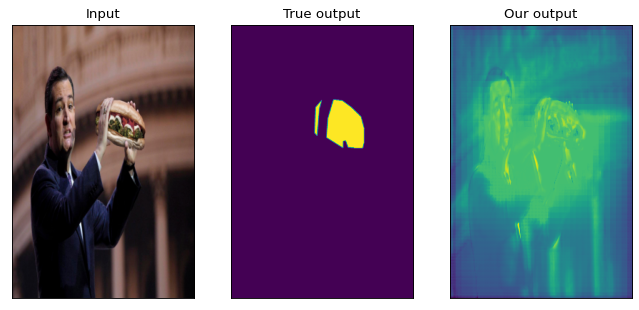


----- Image: 3 -----


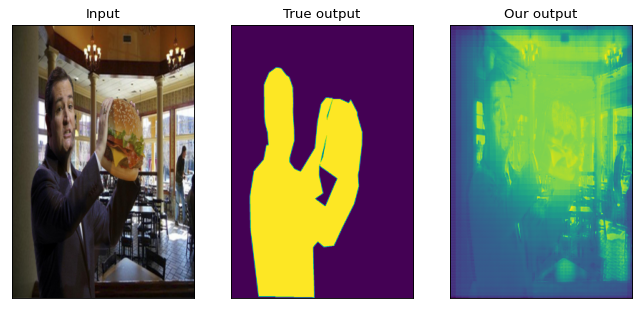


----- Image: 4 -----


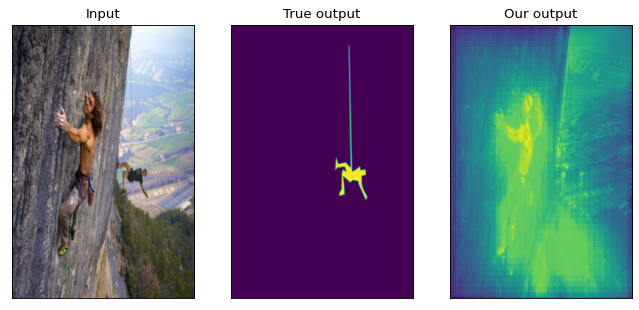

In [113]:
N = 5
pos = []
while len(pos) < N:
  app = np.random.randint(0, len(x_test)-1)
  if not app in pos:
    pos.append(app)

in_m = np.array([x_test[i].cpu().detach().numpy() for i in pos])
in_m = torch.from_numpy(in_m).cuda()
true_out_m = np.array([y_test[i].cpu().detach().numpy() for i in pos])

out_m = []
for i in range(len(in_m)):
  out_m.append(net( torch.from_numpy(in_m[i].cpu().detach().numpy()).cuda().reshape((1, *(x_test[i].shape))) ))

for j in range(len(out_m)):
  print("\n----- Image: %d -----" %j)
  f, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5), dpi=80)
  plt.setp(ax, xticks=[], yticks=[])
  ax[0].title.set_text("Input")
  ax[0].imshow( np.transpose(in_m[j].cpu().detach().numpy(), axes=[1, 2, 0]) )
  ax[1].title.set_text("True output")
  ax[1].imshow( true_out_m[j] )
  ax[2].title.set_text("Our output")
  ax[2].imshow( out_m[j].cpu().detach().numpy().reshape((384, 256)) )
  plt.show()